In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from src.data_loader import *
# # from src.training import *
# from src.visualization import *
# from src.evaluation import *
from sklearn.preprocessing import label_binarize
from PIL import Image
from IPython.display import Image, display
from src.pipeline import *
import joblib
from src.convert_graphml_to_pyg_data_multithread import *
from tqdm import tqdm

import networkx as nx
%aimport src.data_loader
%aimport src.visualization
%aimport src.training
%aimport src.evaluation
%aimport src.pipeline
%aimport src.convert_graphml_to_pyg_data_multithread

tqdm.pandas()

In [3]:
features = [
            "faces", "edges", "vertices", "quantity",
            "height", "width", "depth", "volume", "area",
            "bbox_height", "bbox_width", "bbox_depth", "bbox_volume",
            "bbox_area",
        ]
data = pd.read_csv("./data/synced_dataset.csv")
# data = remove_minority_class(data)
# data[["item_id", "is_cnc", "multiclass_labels"]].head()
data

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,material_id,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold
0,100033,3792.0,11286.0,7524.0,100033_Design_8.step,154.600000,66.000000,154.600000,259187.574998,854521.623711,...,100,[127],https://prod-mv-user-files-upload.s3.eu-centra...,FDM,0,5,E:\gnn_data\graphml_files\100033_Design_8.graphml,E:\gnn_data\pointcloud_files\100033_Design_8.txt,0.0,3.0
1,100034,568.0,1479.0,956.0,100034_5_77_v2.STEP,563.089004,98.888454,518.719571,796131.889763,912613.085344,...,13,[74],https://prod-mv-user-files-upload.s3.eu-centra...,MJF,0,11,E:\gnn_data\graphml_files\100034_5_77_v2.graphml,E:\gnn_data\pointcloud_files\100034_5_77_v2.txt,8.0,6.0
2,100035,216.0,637.0,423.0,100035_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,5.0,0.0
3,100036,216.0,637.0,423.0,100036_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,1.0,2.0
4,100040,216.0,637.0,423.0,100040_00048125_Stator_Pump.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64651,99989,216.0,637.0,423.0,99989_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,804,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99989_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99989_MakerVerse_...,9.0,0.0
64652,99990,60.0,136.0,73.0,99990_240332A01.step,71.000000,100.000000,100.000000,33202.761028,248500.951622,...,1301,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99990_240332A01.graphml,E:\gnn_data\pointcloud_files\99990_240332A01.txt,8.0,3.0
64653,99991,216.0,637.0,423.0,99991_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99991_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99991_MakerVerse_...,8.0,8.0
64654,99993,216.0,637.0,423.0,99993_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99993_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99993_MakerVerse_...,7.0,4.0


In [4]:
step_dir = r"E:\gnn_data\step_files"
data["file_name"] = data["file_name"].apply(lambda x: os.path.join(step_dir, x))

In [5]:
mask = [os.path.exists(file_name) for file_name in data["file_name"]]
data = data[mask].reset_index(drop=True)
data

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,material_id,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold
0,100035,216.0,637.0,423.0,E:\gnn_data\step_files\100035_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,5.0,0.0
1,100036,216.0,637.0,423.0,E:\gnn_data\step_files\100036_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,1.0,2.0
2,100040,216.0,637.0,423.0,E:\gnn_data\step_files\100040_00048125_Stator_...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,0.0,4.0
3,100041,10.0,24.0,16.0,E:\gnn_data\step_files\100041_00048495_Table_L...,60.000000,60.000000,110.000000,25498.294788,198807.075004,...,1311,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100041_00048495_Tabl...,E:\gnn_data\pointcloud_files\100041_00048495_T...,6.0,1.0
4,100042,12.0,22.0,14.0,E:\gnn_data\step_files\100042_00048569_Seal_Ho...,68.503800,49.991283,68.503800,21639.093985,37803.606058,...,1315,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100042_00048569_Seal...,E:\gnn_data\pointcloud_files\100042_00048569_S...,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63348,99989,216.0,637.0,423.0,E:\gnn_data\step_files\99989_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,804,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99989_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99989_MakerVerse_...,9.0,0.0
63349,99990,60.0,136.0,73.0,E:\gnn_data\step_files\99990_240332A01.step,71.000000,100.000000,100.000000,33202.761028,248500.951622,...,1301,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99990_240332A01.graphml,E:\gnn_data\pointcloud_files\99990_240332A01.txt,8.0,3.0
63350,99991,216.0,637.0,423.0,E:\gnn_data\step_files\99991_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99991_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99991_MakerVerse_...,8.0,8.0
63351,99993,216.0,637.0,423.0,E:\gnn_data\step_files\99993_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99993_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99993_MakerVerse_...,7.0,4.0


In [7]:
data = data[data.faces > 0]
data = data[data.edges > 0]
data = data[data.edges > 0]
data = data[
    (data.depth > 0) & (data.width > 0) & (data.height > 0) & (data.area >0) & (data.volume > 0) & (data.volume < 1e8)
    & (data.bbox_depth > 0) & (data.bbox_width > 0) & (data.bbox_height > 0) & (data.bbox_area > 0) & (data.bbox_volume > 0)

]
data.describe()

,item_id,faces,edges,vertices,depth,width,height,area,volume,bbox_depth,bbox_height,bbox_width,bbox_area,bbox_volume,quantity,material_id,is_cnc,multiclass_labels,binary_fold,multiclass_fold
count,63349.000000,63349.000000,63349.000000,63349.000000,63349.000000,63349.000000,63349.000000,6.334900e+04,6.334900e+04,63349.000000,63349.000000,63349.000000,63349.000000,6.334900e+04,6.334900e+04,63349.000000,63349.000000,63349.000000,63349.000000,63349.000000
mean,74828.672134,125.066947,327.314007,206.456771,113.225473,121.436888,90.473379,9.679828e+04,5.254141e+05,59.609266,94.680997,168.583543,59.609266,3.212298e+06,3.377582e+02,977.024894,0.639963,5.634722,4.498382,4.500024
std,29457.434640,276.578270,713.707231,433.929337,191.728234,219.276160,159.931832,4.158965e+05,3.013542e+06,94.365023,143.702033,273.393686,94.365023,5.822033e+07,4.022069e+04,12438.789827,0.480015,6.195370,2.871996,2.871804
min,23481.000000,1.000000,2.000000,1.000000,0.010000,0.009340,0.009321,2.125739e-04,2.325268e-07,0.008472,0.006504,0.009054,0.008472,4.989171e-07,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,49883.000000,23.000000,58.000000,37.000000,21.916283,23.500036,20.000000,5.919545e+03,9.199194e+03,15.000000,21.859465,37.954223,15.000000,2.574396e+04,1.000000e+00,410.000000,0.000000,2.000000,2.000000,2.000000
50%,74257.000000,45.000000,117.000000,76.000000,53.000000,60.000002,40.000000,1.683764e+04,3.737350e+04,29.499413,49.999993,90.000000,29.499413,1.286973e+05,2.000000e+00,808.000000,1.000000,2.000000,4.000000,4.000000
75%,100036.000000,110.000000,294.000000,187.000000,123.800003,134.193359,99.033852,6.117990e+04,2.010507e+05,68.369652,105.000000,180.000007,68.369652,6.748988e+05,6.000000e+00,1300.000000,1.000000,7.000000,7.000000,7.000000
max,125515.000000,13644.000000,31752.000000,17604.000000,5000.000000,5801.998535,5353.802307,2.905170e+07,9.966791e+07,2369.000000,2782.265625,6081.526194,2369.000000,9.832688e+09,9.999999e+06,809000.000000,1.000000,22.000000,9.000000,9.000000


In [14]:
data = data[data.faces < 3000]
data

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,material_id,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold
0,100035,216.0,637.0,423.0,E:\gnn_data\step_files\100035_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,5.0,0.0
1,100036,216.0,637.0,423.0,E:\gnn_data\step_files\100036_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,1.0,2.0
2,100040,216.0,637.0,423.0,E:\gnn_data\step_files\100040_00048125_Stator_...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,0.0,4.0
3,100041,10.0,24.0,16.0,E:\gnn_data\step_files\100041_00048495_Table_L...,60.000000,60.000000,110.000000,25498.294788,198807.075004,...,1311,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100041_00048495_Tabl...,E:\gnn_data\pointcloud_files\100041_00048495_T...,6.0,1.0
4,100042,12.0,22.0,14.0,E:\gnn_data\step_files\100042_00048569_Seal_Ho...,68.503800,49.991283,68.503800,21639.093985,37803.606058,...,1315,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100042_00048569_Seal...,E:\gnn_data\pointcloud_files\100042_00048569_S...,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63348,99989,216.0,637.0,423.0,E:\gnn_data\step_files\99989_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,804,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99989_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99989_MakerVerse_...,9.0,0.0
63349,99990,60.0,136.0,73.0,E:\gnn_data\step_files\99990_240332A01.step,71.000000,100.000000,100.000000,33202.761028,248500.951622,...,1301,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99990_240332A01.graphml,E:\gnn_data\pointcloud_files\99990_240332A01.txt,8.0,3.0
63350,99991,216.0,637.0,423.0,E:\gnn_data\step_files\99991_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99991_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99991_MakerVerse_...,8.0,8.0
63351,99993,216.0,637.0,423.0,E:\gnn_data\step_files\99993_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99993_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99993_MakerVerse_...,7.0,4.0


In [15]:
mask = [os.path.exists(file_name) for file_name in data["graphml_file"]]
data = data[mask].reset_index(drop=True)
data

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,material_id,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold
0,100035,216.0,637.0,423.0,E:\gnn_data\step_files\100035_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,5.0,0.0
1,100036,216.0,637.0,423.0,E:\gnn_data\step_files\100036_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,1.0,2.0
2,100040,216.0,637.0,423.0,E:\gnn_data\step_files\100040_00048125_Stator_...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,0.0,4.0
3,100041,10.0,24.0,16.0,E:\gnn_data\step_files\100041_00048495_Table_L...,60.000000,60.000000,110.000000,25498.294788,198807.075004,...,1311,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100041_00048495_Tabl...,E:\gnn_data\pointcloud_files\100041_00048495_T...,6.0,1.0
4,100042,12.0,22.0,14.0,E:\gnn_data\step_files\100042_00048569_Seal_Ho...,68.503800,49.991283,68.503800,21639.093985,37803.606058,...,1315,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100042_00048569_Seal...,E:\gnn_data\pointcloud_files\100042_00048569_S...,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63286,99989,216.0,637.0,423.0,E:\gnn_data\step_files\99989_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,804,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99989_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99989_MakerVerse_...,9.0,0.0
63287,99990,60.0,136.0,73.0,E:\gnn_data\step_files\99990_240332A01.step,71.000000,100.000000,100.000000,33202.761028,248500.951622,...,1301,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99990_240332A01.graphml,E:\gnn_data\pointcloud_files\99990_240332A01.txt,8.0,3.0
63288,99991,216.0,637.0,423.0,E:\gnn_data\step_files\99991_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99991_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99991_MakerVerse_...,8.0,8.0
63289,99993,216.0,637.0,423.0,E:\gnn_data\step_files\99993_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99993_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99993_MakerVerse_...,7.0,4.0


In [17]:
# Define target directories
step_target_dir = Path(r"E:\gnn_data\step_files_final")
graphml_target_dir = Path(r"E:\gnn_data\graphml_files_final")

# Create target dirs if they don’t exist
os.makedirs(step_target_dir, exist_ok=True)
os.makedirs(graphml_target_dir, exist_ok=True)

# Loop through the DataFrame rows
for idx, row in tqdm(data.iterrows()):
    step_src = Path(row['file_name'])
    graphml_src = Path(row['graphml_file'])

    # Move STEP file
    if step_src.exists():
        step_src.rename(step_target_dir / step_src.name)

    # Move GraphML file
    if graphml_src.exists():
        graphml_src.rename(graphml_target_dir / graphml_src.name)

63291it [00:23, 2727.48it/s]


In [18]:
data.to_csv("./data/synced_dataset_final.csv", index=False)

In [22]:
data2 = pd.read_csv("./data/synced_dataset_final.csv")
data2.rename(columns={"file_name": "step_file"}, inplace=True)

In [24]:
data2.to_csv(r"./data/synced_dataset_final.csv", index=False)

In [123]:
data_no_outliers = data[(data['volume'] > 0) & (data['volume'] < 1e8)].reset_index(drop=True)

<Axes: title={'center': 'Volume Distribution'}>

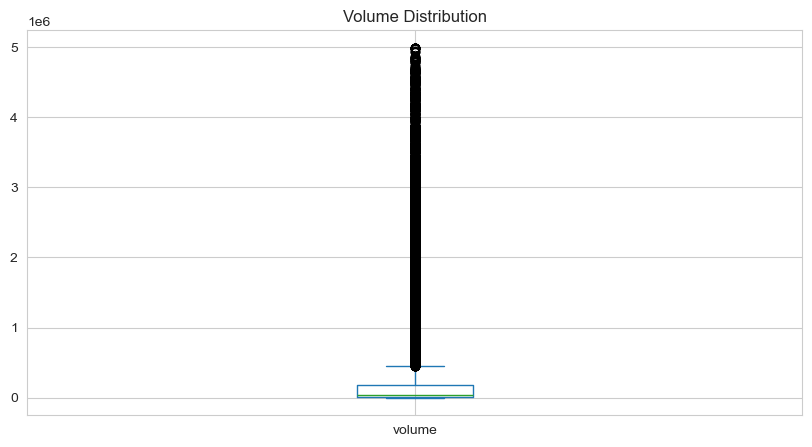

In [79]:
data_no_outliers.volume.plot(kind="box", figsize=(10, 5), title="Volume Distribution")

In [88]:
len(data[data.volume > 1e8].file_name.tolist())

57

In [98]:
to_remove = data[data.vertices == 0].file_name.tolist()
# Move files to "outliers" directory
for file in os.listdir(r"E:\gnn_data\step_files"):
    if file in to_remove:
        src = os.path.join(r"E:\gnn_data\step_files", file)
        dst = os.path.join(r"E:\gnn_data\step_files\outliers", file)
        os.rename(src, dst)


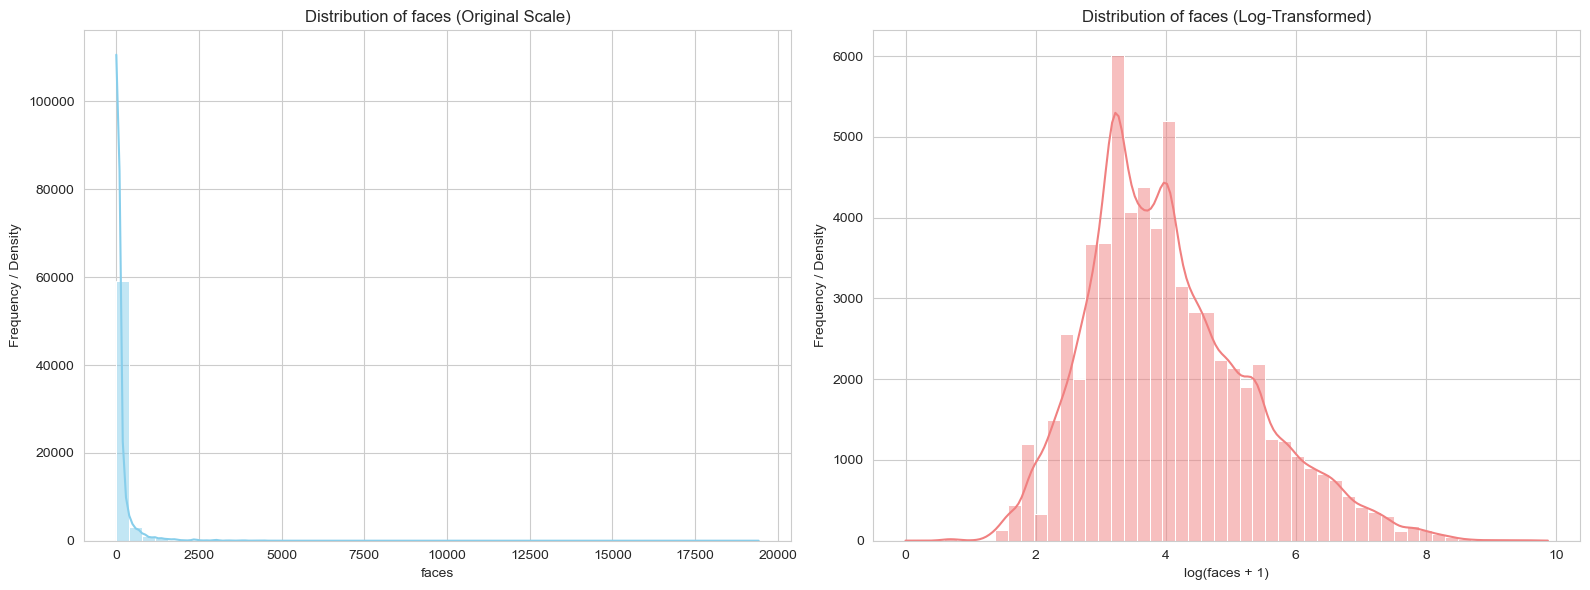

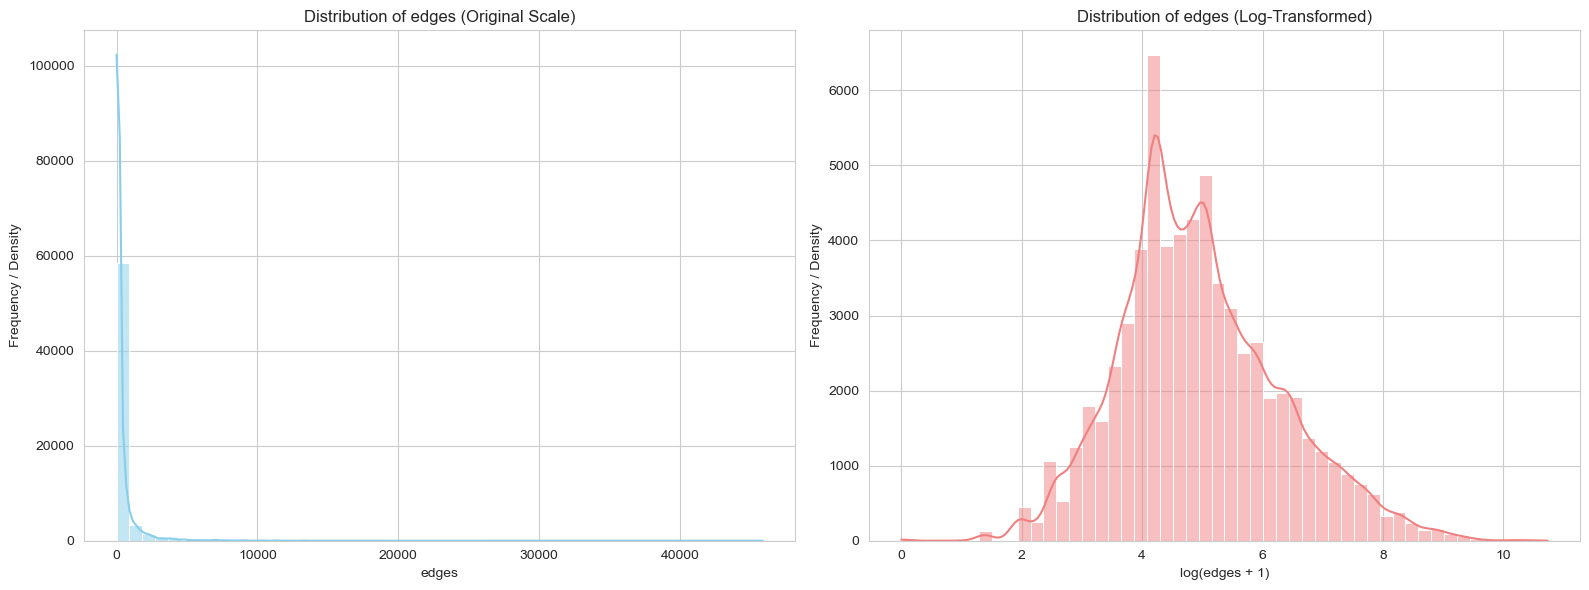

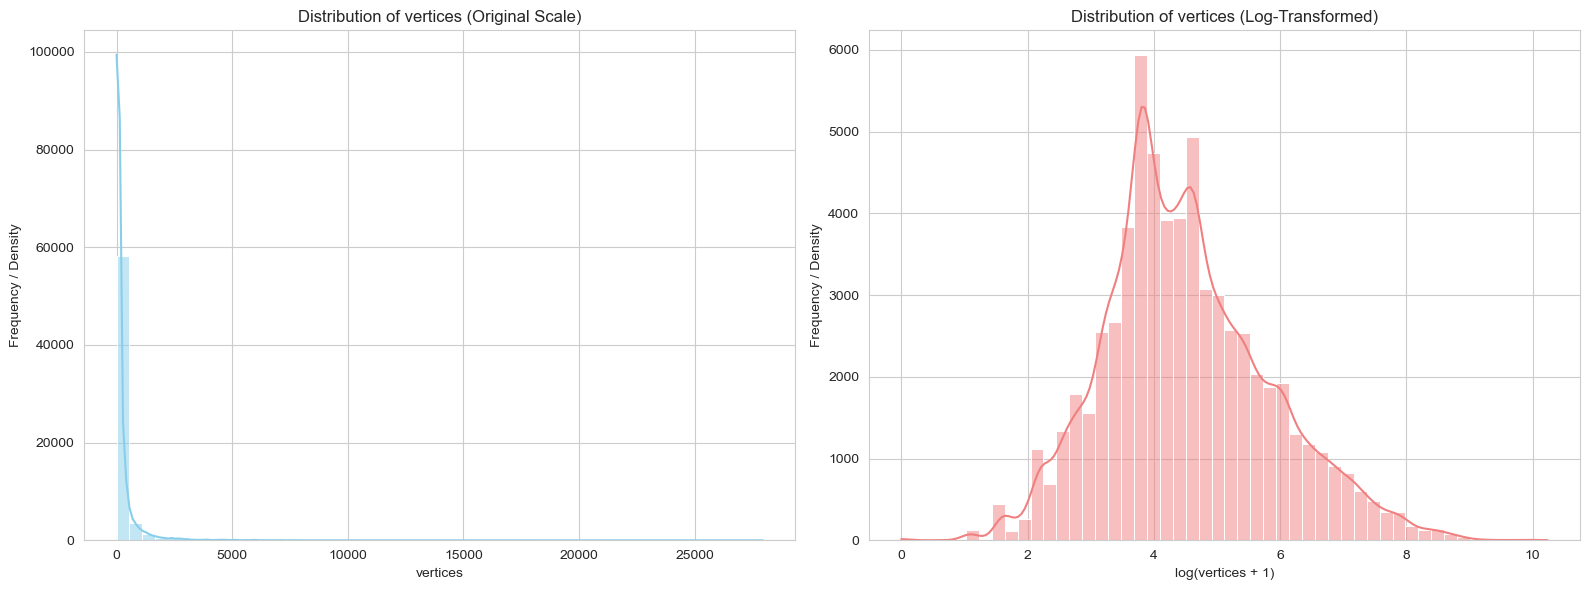

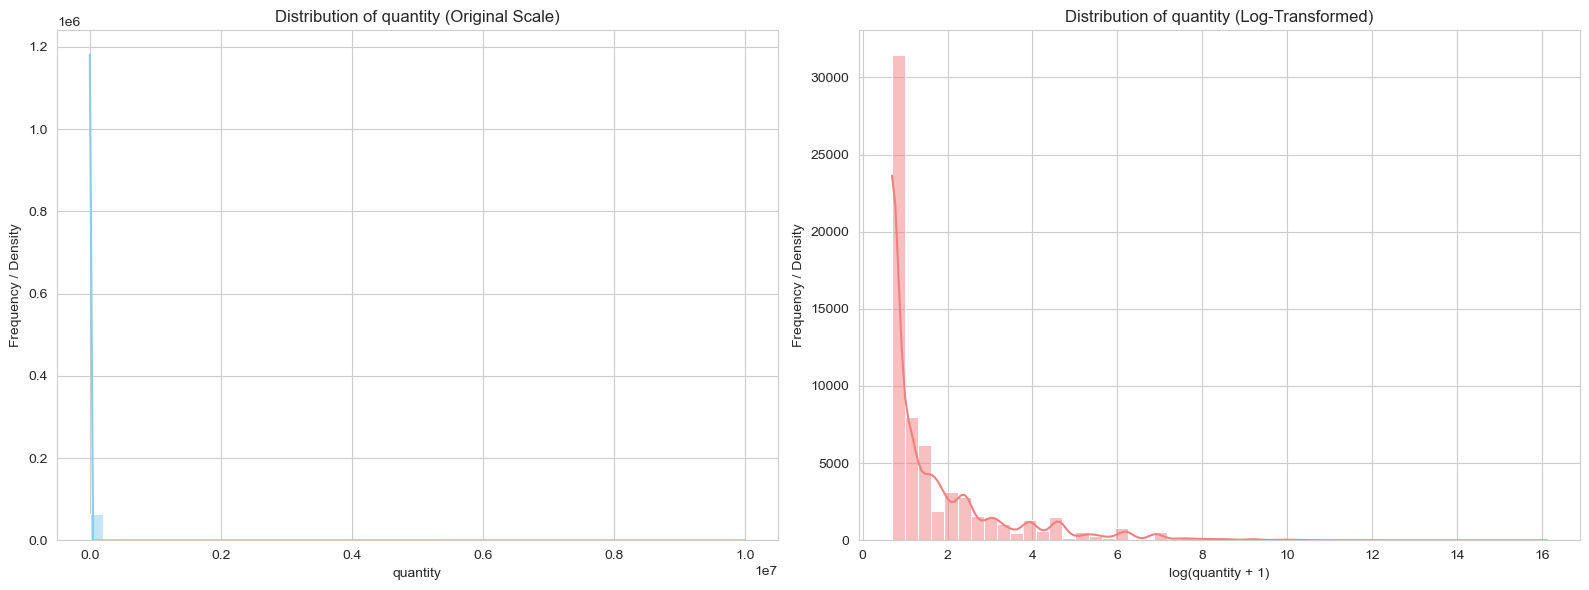

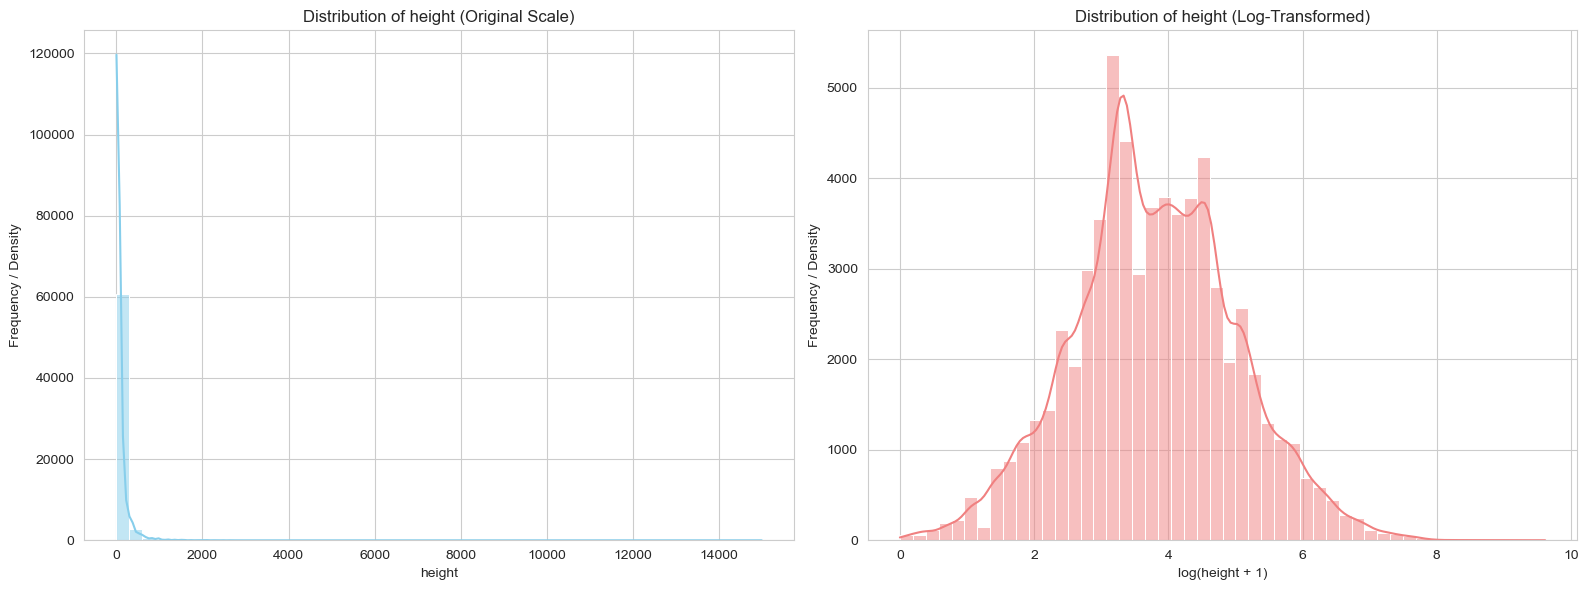

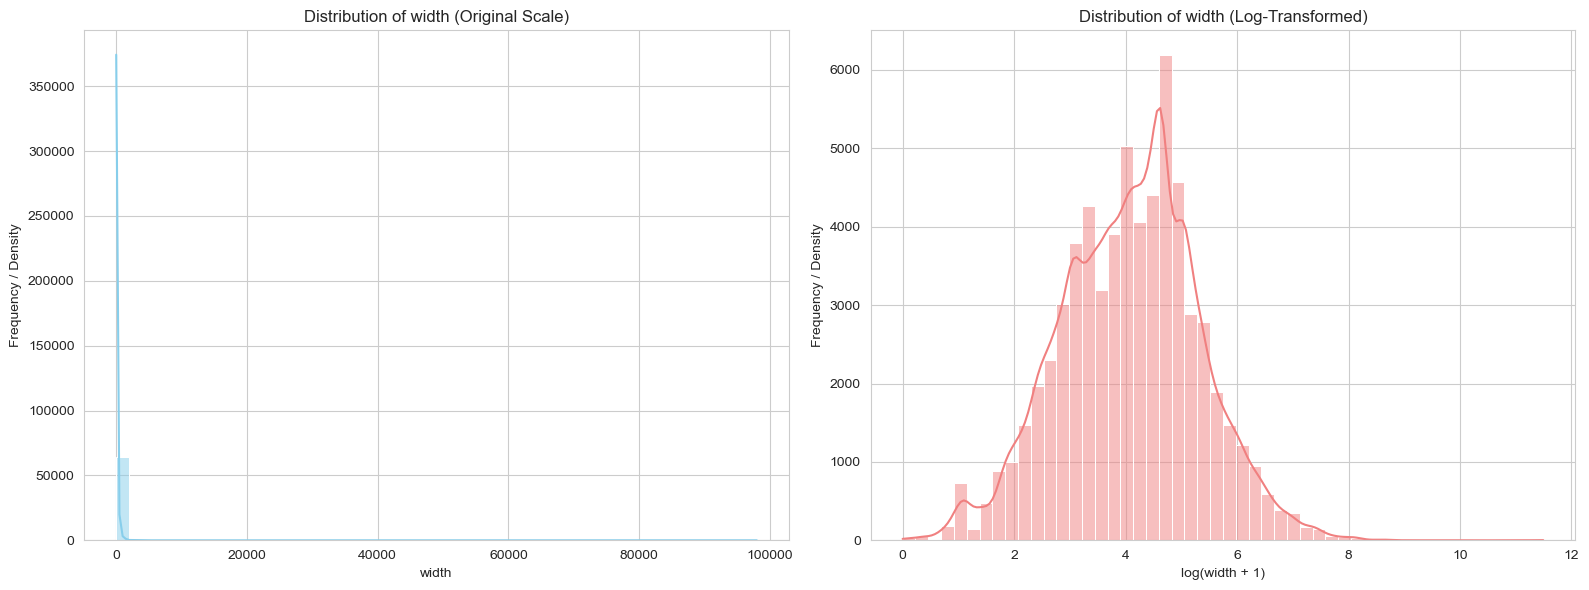

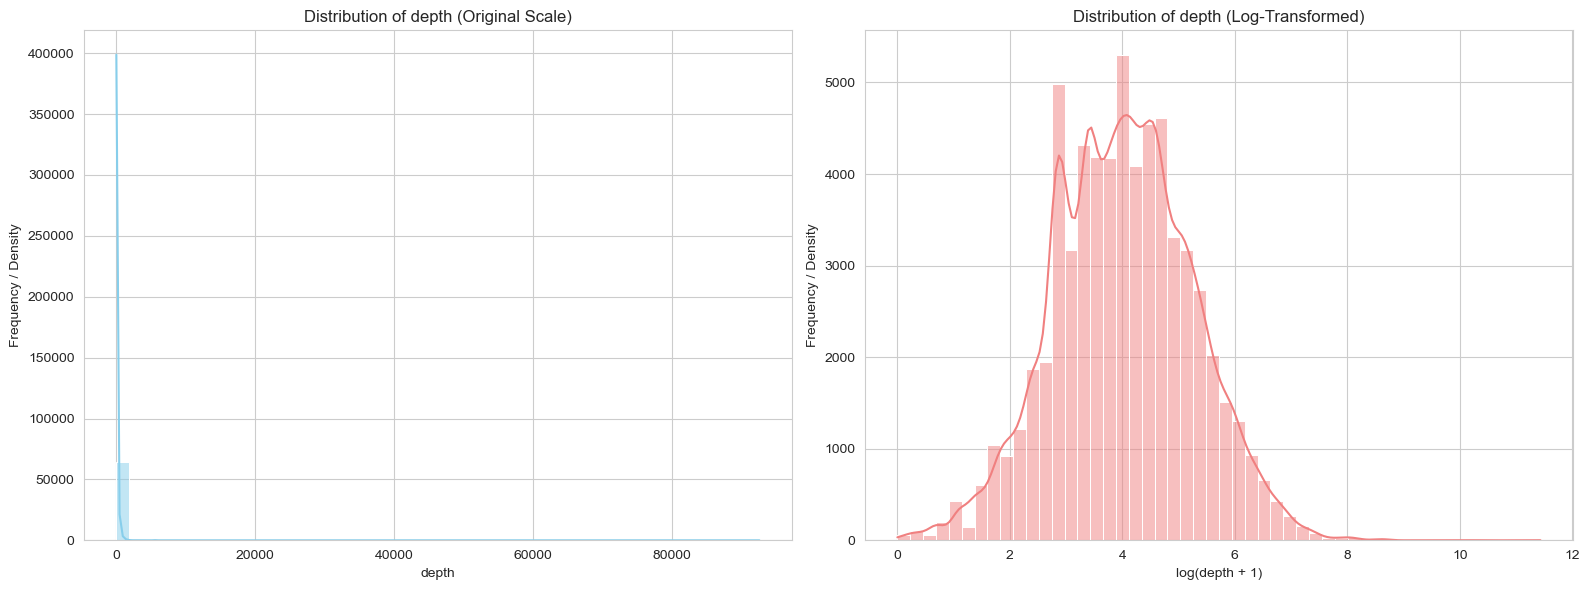

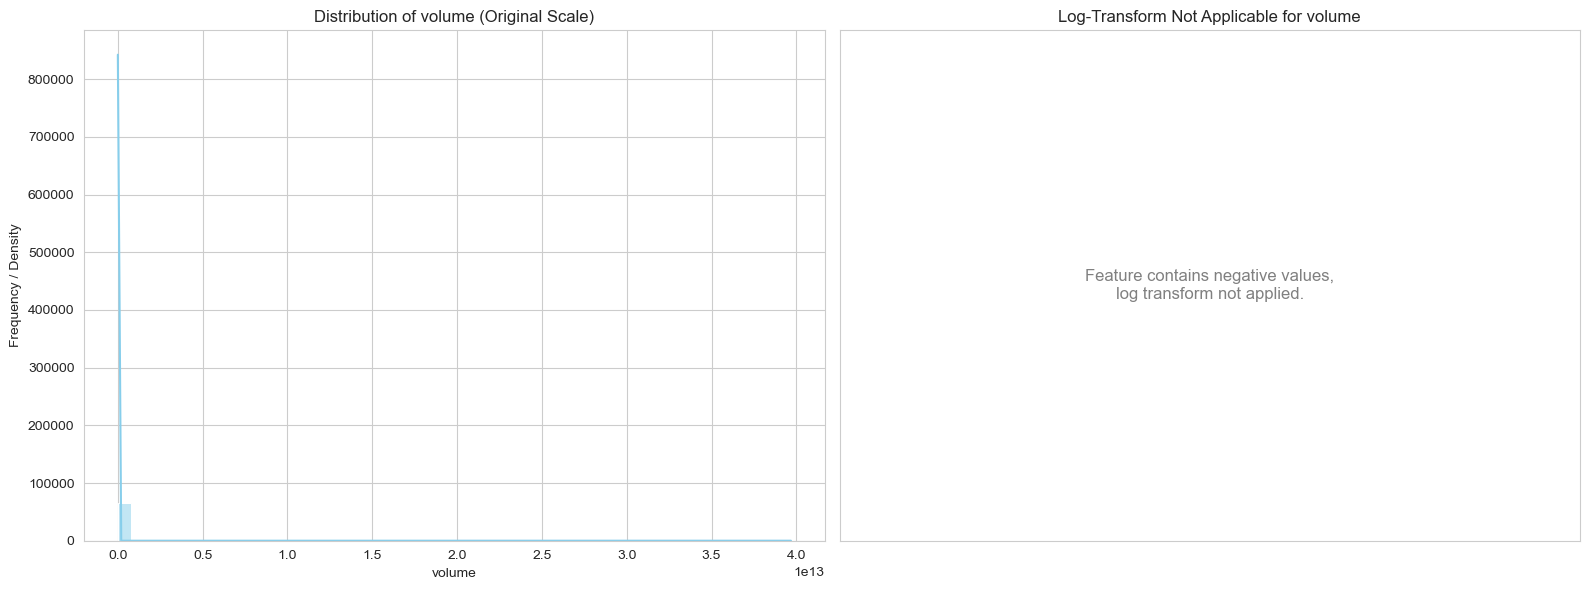

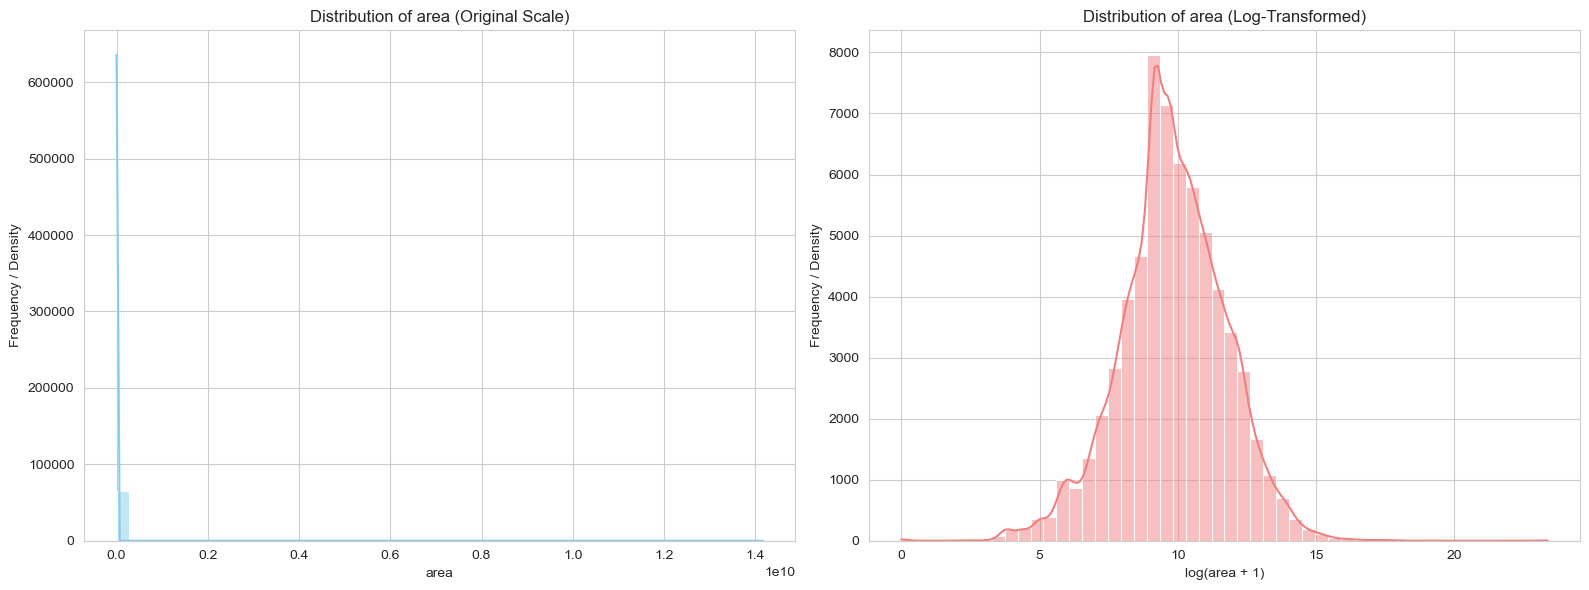

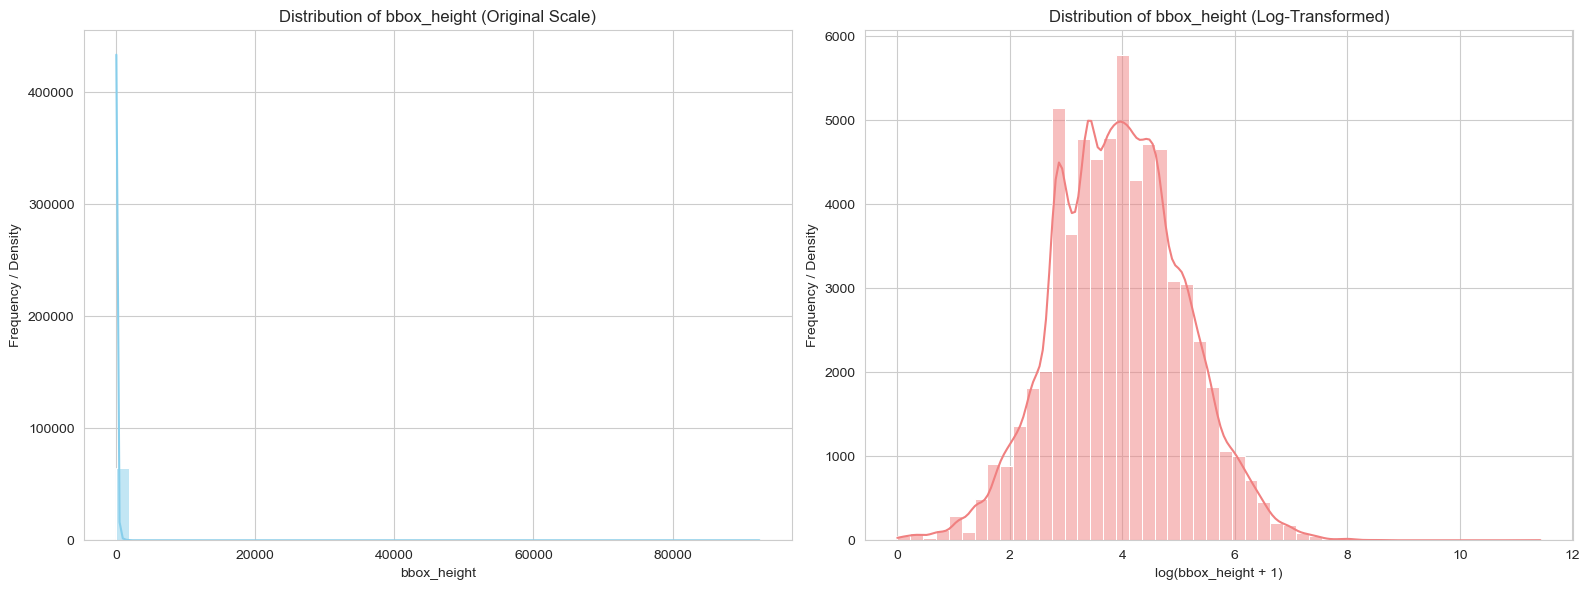

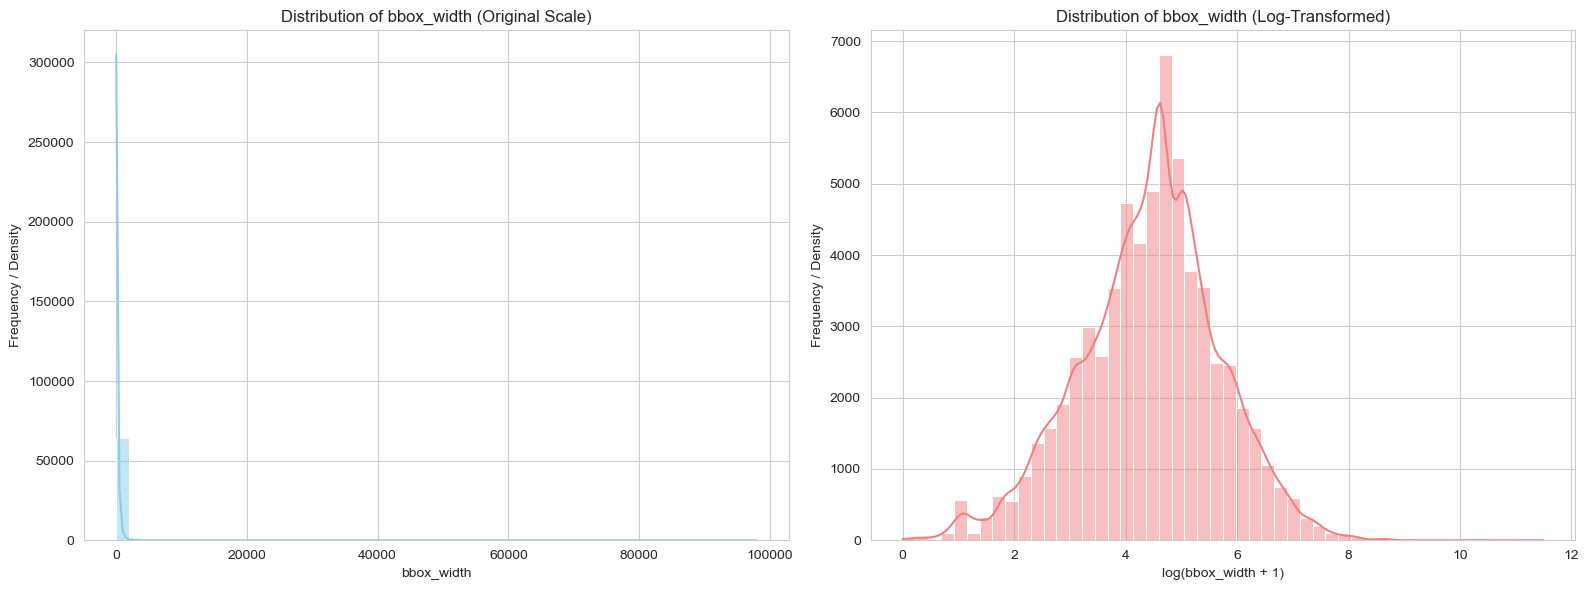

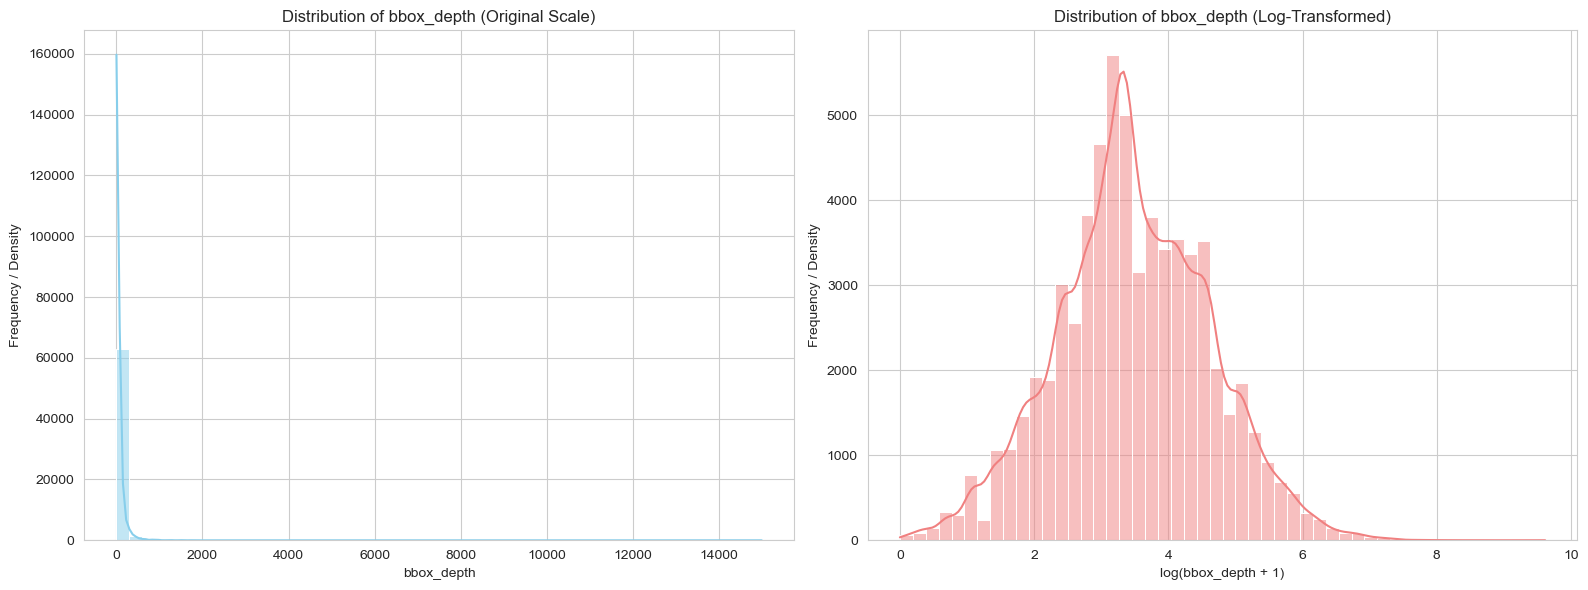

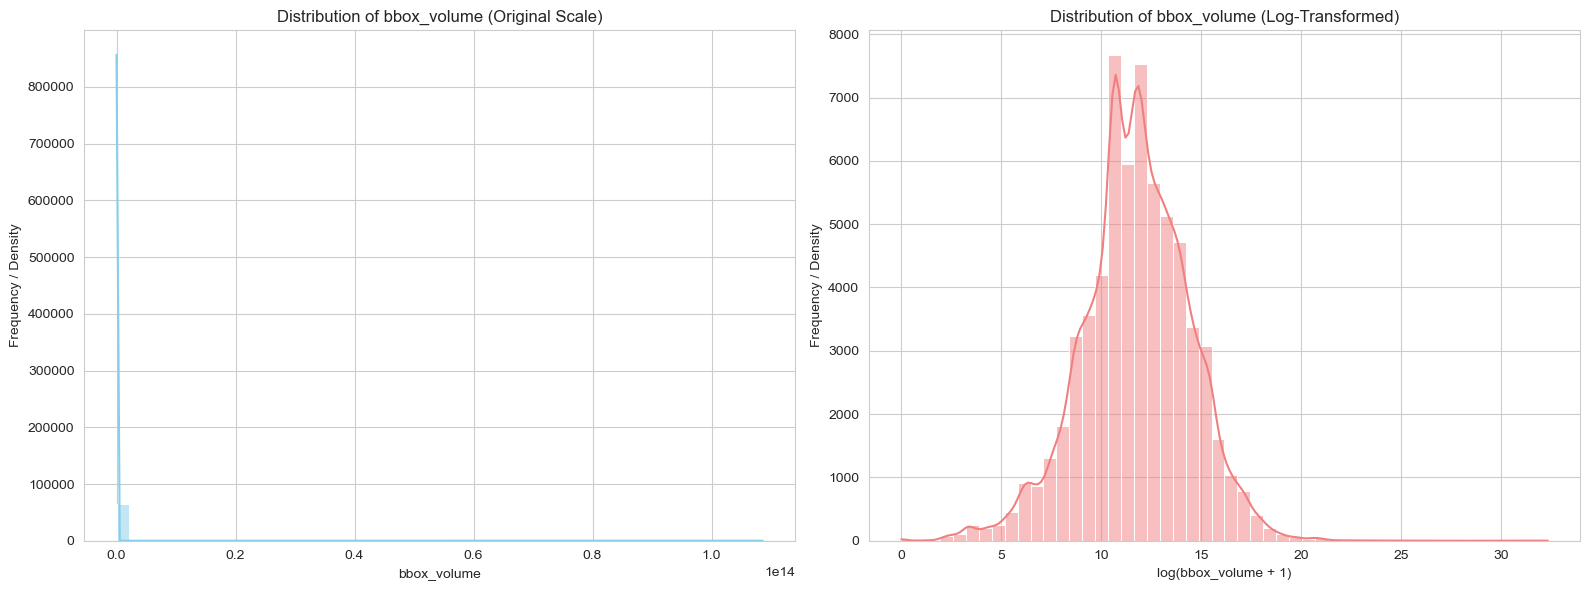

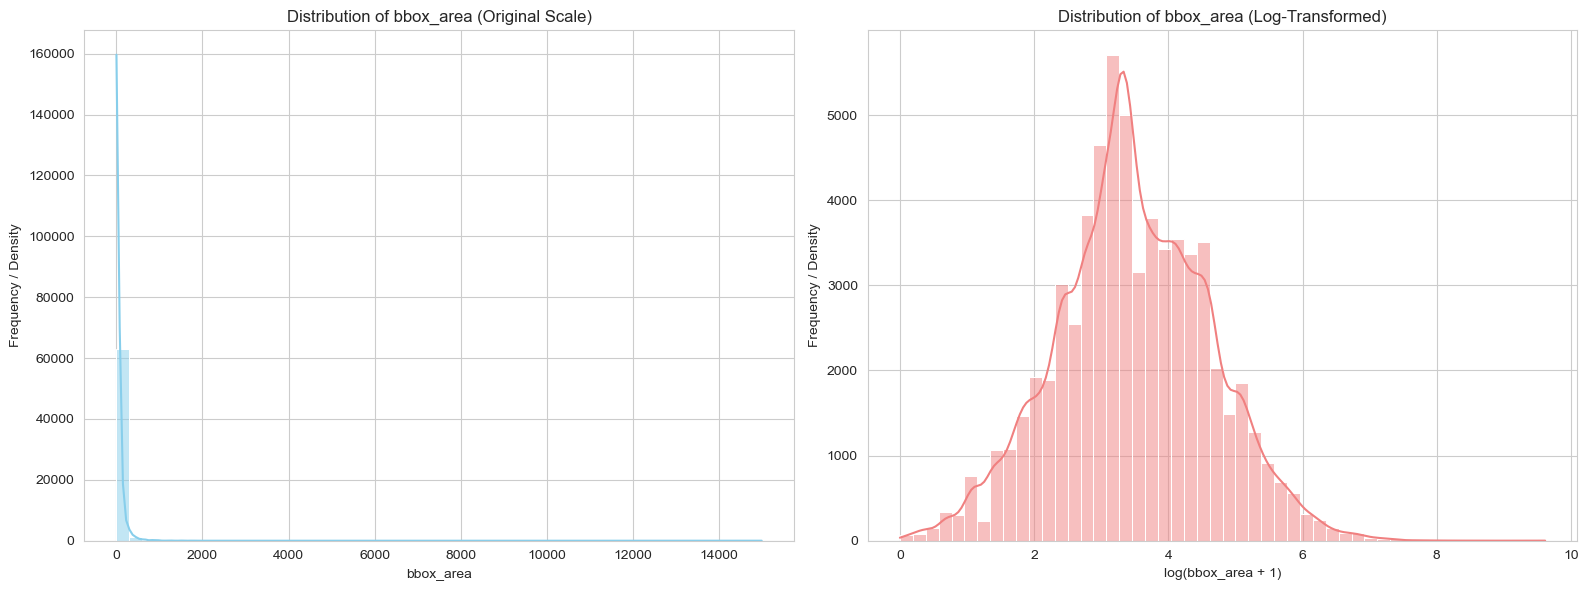

In [34]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5) # Default figure size for each plot

# Iterate through each feature and plot its distribution
for feature in features:
    if feature not in data.columns:
        continue # Skip if feature was not found in the DataFrame

    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Create a figure with two subplots

    # Plot original distribution
    sns.histplot(data[feature], kde=True, ax=axes[0], color='skyblue', bins=50)
    axes[0].set_title(f'Distribution of {feature} (Original Scale)')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Frequency / Density')

    # Plot log-transformed distribution (using log1p to handle zeros/small values)
    # Only apply log transform if the feature can reasonably be logged (i.e., non-negative)
    if (data[feature] >= 0).all(): # Check if all values are non-negative
        log_feature_name = f'log_{feature}'
        data[log_feature_name] = np.log1p(data[feature]) # log(x+1)

        sns.histplot(data[log_feature_name], kde=True, ax=axes[1], color='lightcoral', bins=50)
        axes[1].set_title(f'Distribution of {feature} (Log-Transformed)')
        axes[1].set_xlabel(f'log({feature} + 1)')
        axes[1].set_ylabel('Frequency / Density')
    else:
        # If feature contains negative values, log transform is not directly applicable
        axes[1].set_title(f'Log-Transform Not Applicable for {feature}')
        axes[1].text(0.5, 0.5, 'Feature contains negative values,\nlog transform not applied.',
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[1].transAxes, fontsize=12, color='gray')
        axes[1].set_xticks([])
        axes[1].set_yticks([])

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

In [27]:
global_feature = np.array(data.iloc[5000][features].values, dtype=np.float32)
global_feature.dtype
# global_feature_tensor = torch.tensor(global_feature, dtype=torch.float32).squeeze(0)
# global_feature_tensor

dtype('float32')

In [32]:
np.array(data[data["file_name"].str.startswith("100041")][features].values)

array([[1.00000000e+01, 2.40000000e+01, 1.60000000e+01, 1.00000000e+00,
        1.10000000e+02, 6.00000000e+01, 6.00000000e+01, 1.98807075e+05,
        2.54982948e+04, 6.00000000e+01, 6.00000000e+01, 1.10000000e+02,
        3.96000000e+05, 1.10000000e+02]])

In [4]:
train_data = data[data.binary_fold == 0].reset_index(drop=True)
X = train_data[features]
X_train, X_test, y_train_index, y_test_index = train_test_split(
            X,
            range(len(X)),
            test_size=0.2,
            random_state=42,
            stratify=train_data["is_cnc"],
        )

In [15]:
result_binary, result_multi = training_one_fold(dataset=data)

Training fold 0...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...


In [16]:
result_binary

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9
accuracy,0.774322,0.762360,0.744817,0.754386,0.767145,0.783892,0.780702,0.789474,0.772727,0.775120
f1_macro,0.759934,0.741529,0.725581,0.736817,0.748903,0.769533,0.766913,0.774013,0.756577,0.759871
f1_weighted,0.775306,0.760722,0.744585,0.754603,0.766605,0.784580,0.781742,0.789474,0.772977,0.775699
roc_auc,0.832267,0.823100,0.817507,0.816992,0.831570,0.845355,0.844312,0.836582,0.810040,0.846106
average_precision,0.889847,0.876174,0.876118,0.869002,0.881544,0.894221,0.887809,0.881222,0.847006,0.894130


In [10]:
df_result = pd.DataFrame(result_binary)
df_result.T

,0,1
accuracy,0.774322,0.762360
f1_macro,0.759934,0.741529
f1_weighted,0.775306,0.760722
roc_auc,0.832267,0.823100
average_precision,0.889847,0.876174


In [6]:
features = [
    "faces", "edges", "vertices", "quantity",
    "height", "width", "depth", "volume", "area",
    "bbox_height", "bbox_width", "bbox_depth", "bbox_volume", "bbox_area",
]
X = data[features]


In [7]:
X_train, X_test, y_train_index, y_test_index = train_test_split(X, range(len(X)), test_size=0.2, random_state=42, stratify=data["multiclass_labels"])
y_multi_train = data["multiclass_labels"].iloc[y_train_index]
y_multi_test = data["multiclass_labels"].iloc[y_test_index]

y_binary_train = data["is_cnc"].iloc[y_train_index]
y_binary_test = data["is_cnc"].iloc[y_test_index]


params = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
}

In [8]:
best_search_multi = randomizedsearchcv_xgboost(X_train, y_multi_train, params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.8s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.4s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.5s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.7s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.7s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.5

In [9]:
# Save model to disk
joblib.dump(best_search_multi, "./models/best_model_multi.pkl")

['./models/best_model_multi.pkl']

In [10]:
best_search_binary = randomizedsearchcv_xgboost(X_train, y_binary_train, params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.0s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.0s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1

In [11]:
# Save model to disk
joblib.dump(best_search_binary, "./models/best_model_binary.pkl")

['./models/best_model_binary.pkl']

In [12]:
# Load models from disk
best_search_multi = joblib.load("./models/best_model_multi.pkl")
best_search_binary = joblib.load("./models/best_model_binary.pkl")

# Multiclass predictions
y_multi_pred = best_search_multi.best_estimator_.predict(X_test)
y_multi_prob = best_search_multi.best_estimator_.predict_proba(X_test)

# Binary predictions
y_binary_pred = best_search_binary.best_estimator_.predict(X_test)
y_binary_prob = best_search_binary.best_estimator_.predict_proba(X_test)

In [19]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Multiclass AUROC
auc_roc_multi = roc_auc_score(y_multi_test, y_multi_prob, multi_class='ovr', average='macro')

# Multiclass Average Precision
avg_precision_multi = average_precision_score(y_multi_test, y_multi_prob, average='macro')
display(auc_roc_multi, avg_precision_multi)

0.9159675993547275

0.6042723452036123

In [43]:
# Binary AUROC
auc_roc_binary = roc_auc_score(y_binary_test, y_binary_prob[:, 1])

# Binary Average Precision
avg_precision_binary = average_precision_score(y_binary_test, y_binary_prob[:, 1])
display(auc_roc_binary, avg_precision_binary)

0.9380131889158437

0.9580794635640363

In [41]:
y_binary_prob

array([[0.9459677 , 0.05403232],
       [0.04010487, 0.95989513],
       [0.04546088, 0.9545391 ],
       ...,
       [0.8093872 , 0.19061282],
       [0.01354468, 0.9864553 ],
       [0.9790657 , 0.02093427]], dtype=float32)

In [44]:
print("Multi-Class Model Evaluation")
metrics_multi = evaluate_classification(
    y_true=y_multi_test,
    y_pred=y_multi_pred,
    y_prob=y_multi_prob,
    # top_k=3
)
pprint(metrics_multi)
le = joblib.load("./models/label_encoder.pkl")
# print_classification_report(y_multi_test, y_multi_pred)

# df_multi_class_accuracy = compute_per_class_accuracy(y_multi_test, y_multi_pred, le)
# pprint(df_multi_class_accuracy)

Multi-Class Model Evaluation
{'accuracy': 0.7417630634224173,
 'average_precision': 0.6042723452036123,
 'f1_macro': 0.593230863615564,
 'f1_weighted': 0.7482129409505707,
 'roc_auc': 0.9159675993547275}


In [45]:
print("Binary Model Evaluation")
metrics_binary = evaluate_classification(
    y_true=y_binary_test,
    y_pred=y_binary_pred,
    y_prob=y_binary_prob,
)
pprint(metrics_binary)

# print_classification_report(y_binary_test, y_binary_pred)

Binary Model Evaluation
{'accuracy': 0.8742720382927802,
 'average_precision': 0.9580794635640363,
 'f1_macro': 0.8662770422115723,
 'f1_weighted': 0.8748459042431443,
 'roc_auc': 0.9380131889158437}


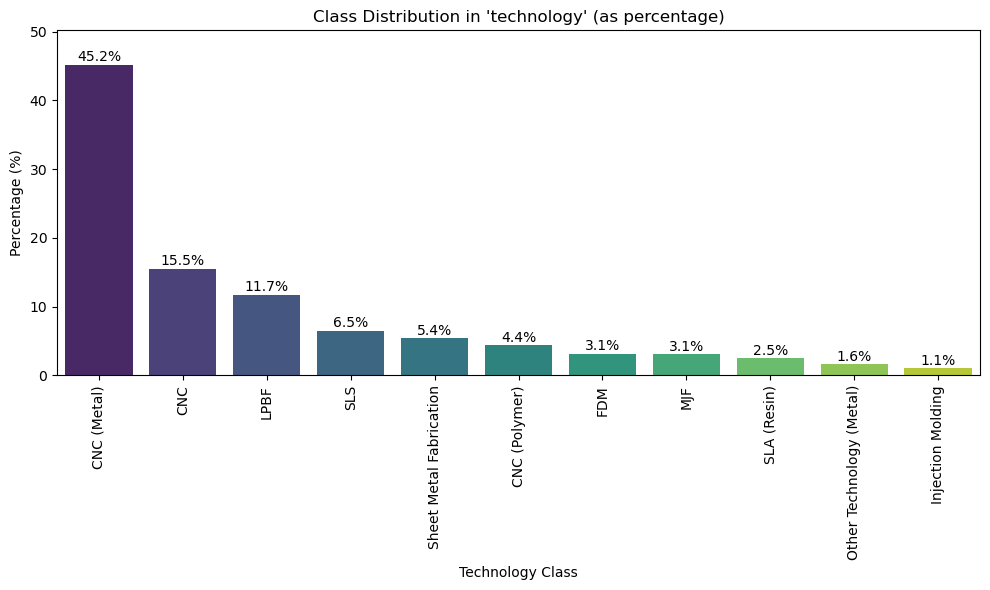

In [73]:
plot_class_distribution(data)

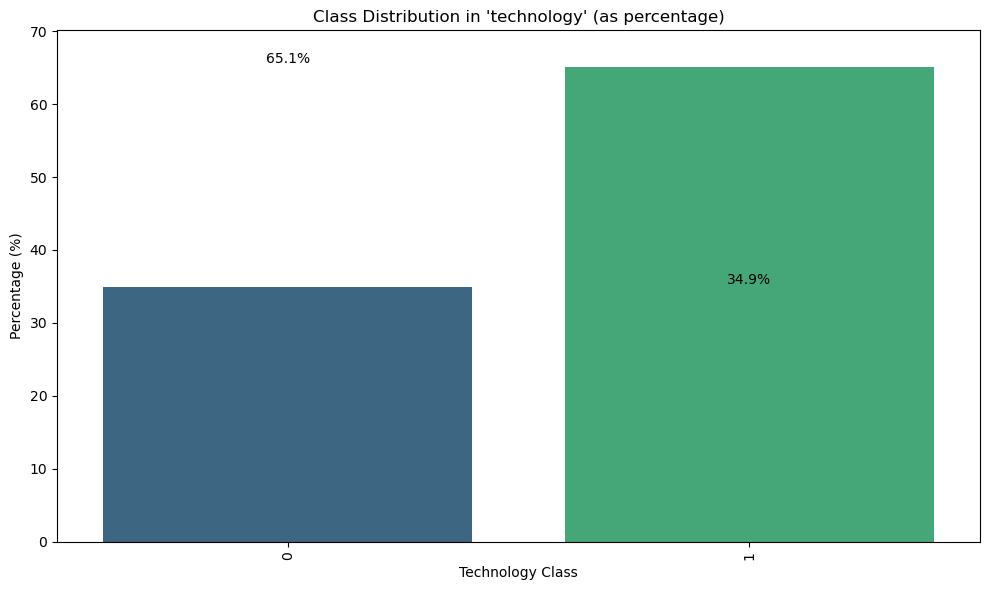

In [76]:
plot_class_distribution(data, target_col="Is_CNC")

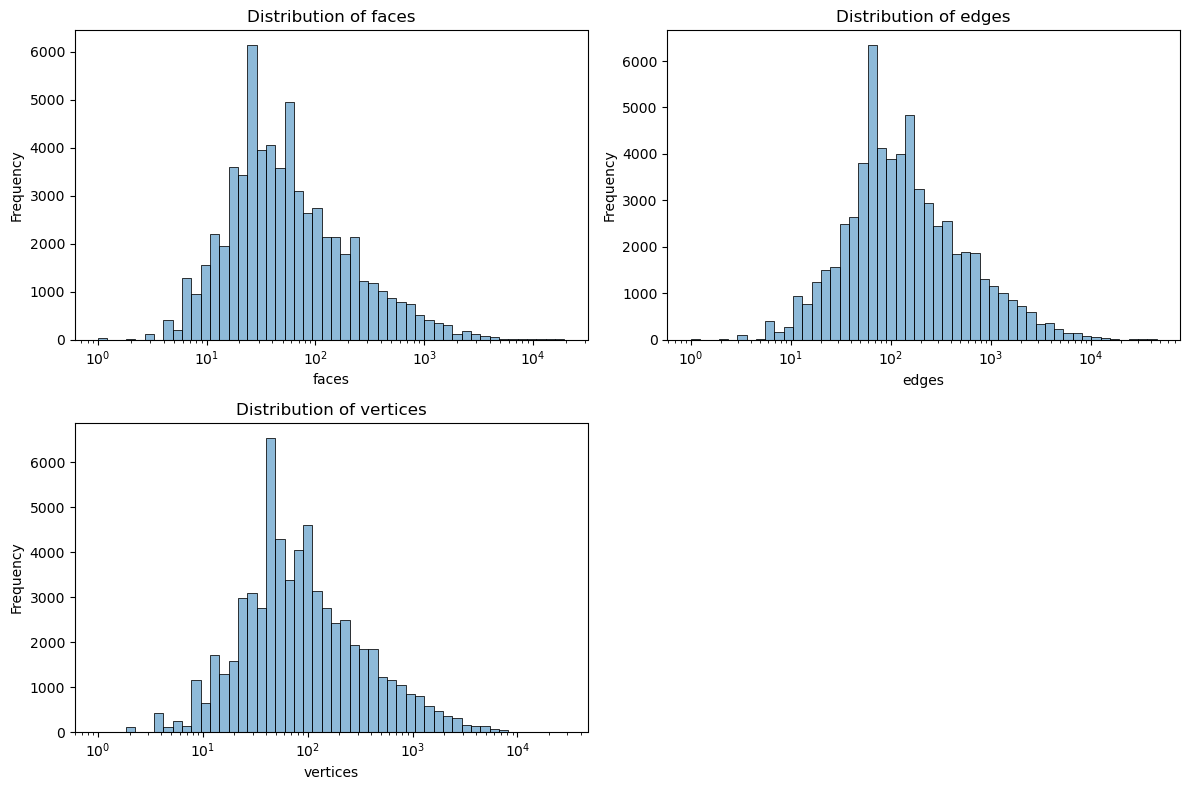

In [75]:
plot_topological_features_distribution(data, ["faces", "edges", "vertices"])

In [77]:
data.Is_CNC.value_counts()

Is_CNC
1    41019
0    21987
Name: count, dtype: int64

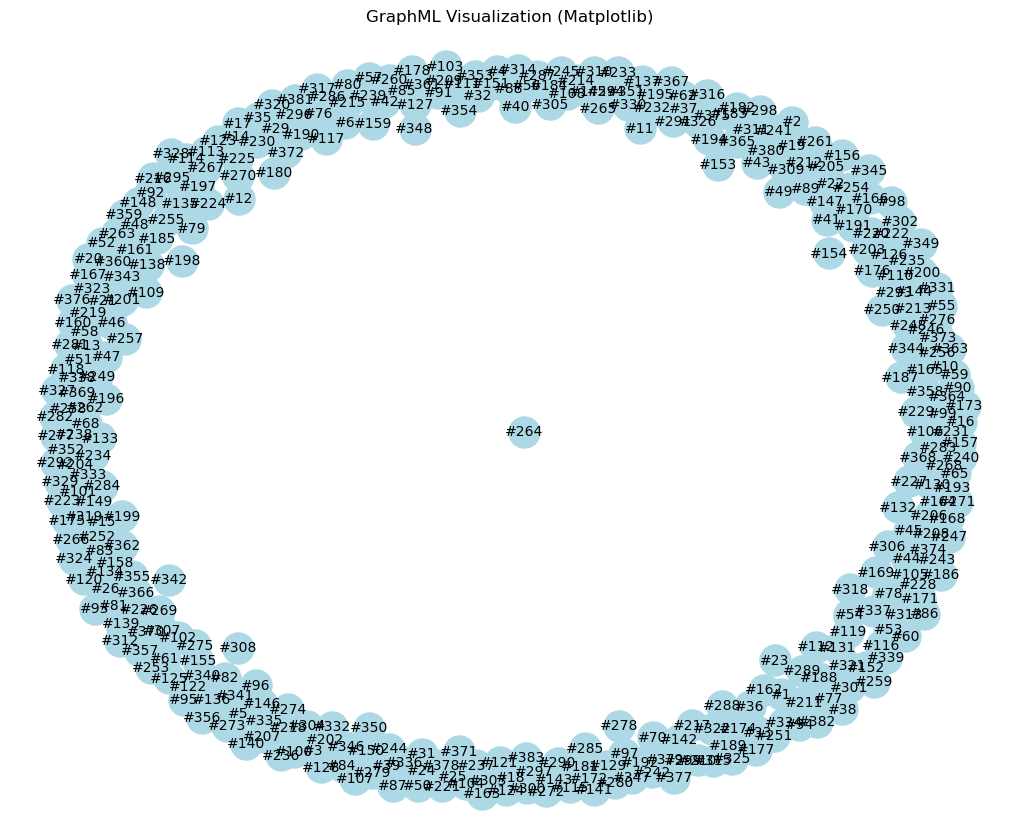

In [59]:
display_graphml_matplotlib(r"E:\gnn_data\graphml_files\100042_00048569_Seal_Holder_step_002.graphml")

In [9]:
G = nx.read_graphml(r"E:\step_files_graph\square_pocket.step.graphmlsquare_pocket.graphml")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 337
Number of edges: 394


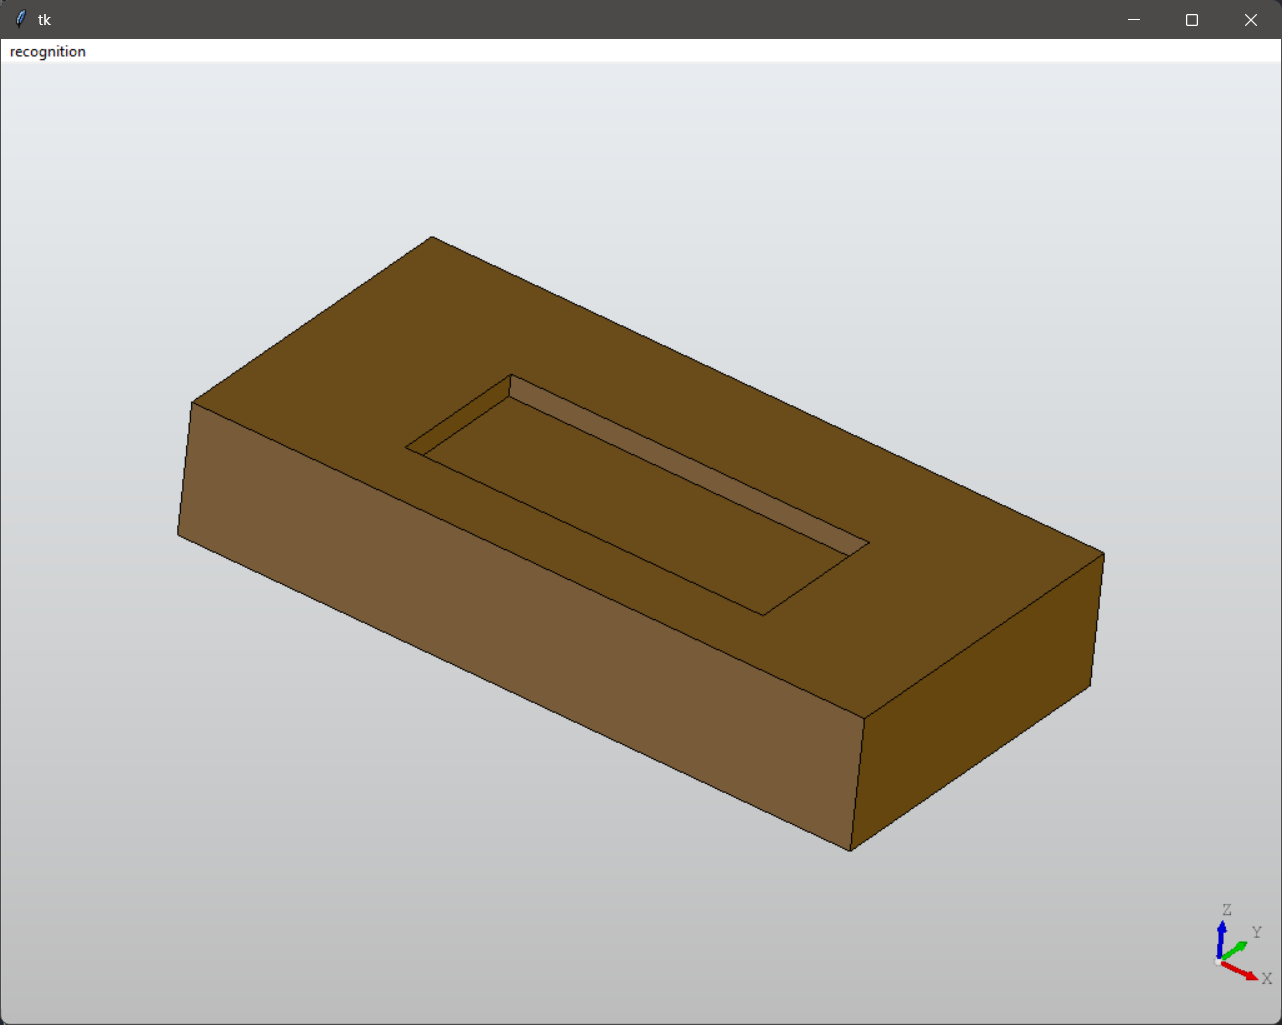

In [7]:
# display image from disk
display(Image(r"E:\2025-05-13.png"))

In [ ]:
G = nx.read_graphml(r"E:\step_files_test\square_pocket.step")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

In [31]:
df_na = df.dropna()

In [1]:
xgboost_scores = [0.83, 0.81, 0.80, 0.79, 0.82]
pointnet_scores = [0.84, 0.86, 0.83, 0.85, 0.87]
from scipy.stats import ttest_rel
ttest_rel(xgboost_scores, pointnet_scores)

TtestResult(statistic=-4.472135954999578, pvalue=0.011056493393450087, df=4)

In [5]:
data = pd.read_csv("./data/synced_dataset.csv")
data.head()

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size,step_file_path
0,100033,3792.0,11286.0,7524.0,100033_Design_8.step,154.600000,66.000000,154.600000,259187.574998,854521.623711,...,https://prod-mv-user-files-upload.s3.eu-centra...,FDM,0,5,E:\gnn_data\graphml_files\100033_Design_8.graphml,E:\gnn_data\pointcloud_files\100033_Design_8.txt,7.0,5.0,7196375,E:\gnn_data\step_files\100033_Design_8.step
1,100034,568.0,1479.0,956.0,100034_5_77_v2.STEP,563.089004,98.888454,518.719571,796131.889763,912613.085344,...,https://prod-mv-user-files-upload.s3.eu-centra...,MJF,0,11,E:\gnn_data\graphml_files\100034_5_77_v2.graphml,E:\gnn_data\pointcloud_files\100034_5_77_v2.txt,1.0,5.0,8983582,E:\gnn_data\step_files\100034_5_77_v2.STEP
2,100035,216.0,637.0,423.0,100035_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,1.0,6.0,421897,E:\gnn_data\step_files\100035_MakerVerse_Sampl...
3,100036,216.0,637.0,423.0,100036_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,2.0,7.0,421897,E:\gnn_data\step_files\100036_MakerVerse_Sampl...
4,100040,216.0,637.0,423.0,100040_00048125_Stator_Pump.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,4.0,4.0,421899,E:\gnn_data\step_files\100040_00048125_Stator_...


In [6]:
data[data.file_name.str.startswith("23580_006")]

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size,step_file_path
15886,23580,27.0,68.0,42.0,23580_006_TopCoverRFID_Magnelis_3mm_test.STEP,4.0,154.199997,184.850006,55587.419272,100869.209004,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\23580_006_TopCoverRF...,E:\gnn_data\pointcloud_files\23580_006_TopCove...,0.0,2.0,59189,E:\gnn_data\step_files\23580_006_TopCoverRFID_...


In [36]:
import os

data['step_file_path'] = data['file_name'].map(lambda x: os.path.join(r"E:\gnn_data\step_files", x))


In [38]:
data['file_size'] = data['step_file_path'].map(os.path.getsize)

In [ ]:
data.head()

In [49]:
data.to_csv("./data/synced_dataset.csv", index=False)

In [32]:
data[data.file_size == 0]

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size
326,100498,60.0,140.0,91.0,100498_10199000001120240417_tz_extruder_victor...,148.109545,46.334813,46.03492,33365.703787,124584.383076,...,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100498_1019900000112...,E:\gnn_data\pointcloud_files\100498_1019900000...,4.0,8.0,0


In [57]:
import torch.nn as nn
import torch
embed = nn.Embedding(392, 32)

In [58]:
with open(r"type_embedding.pkl", "wb") as f:
    joblib.dump(embed, f)

In [49]:
label = 0
type_embedding = joblib.load(r"type_embedding.pkl")
with open(r"all_attribute_type.pkl", "rb") as f:
    all_attribute_type = sorted(list(joblib.load(f)))
node_type_index = {node_type: idx for idx, node_type in enumerate(all_attribute_type)}

In [50]:
graphml_path = r"E:\gnn_data\graphml_files\65905_Stator_1030_segmented_end_round.graphml"
G = nx.read_graphml(graphml_path)
data = enhanced_convert_graph(G, label, node_type_index, type_embedding)

WTF IS GOING ON


In [54]:
data.x

tensor([[ 2.0000e+00,  2.9155e-03,  0.0000e+00,  ...,  1.0515e+00,
         -7.0160e-01, -1.8312e-01],
        [ 3.0000e+00,  4.3732e-03,  0.0000e+00,  ...,  1.2171e+00,
          7.7657e-02,  5.7191e-02],
        [ 2.0000e+00,  2.9155e-03,  5.8479e-05,  ..., -1.1482e+00,
         -1.2018e+00, -8.5696e-01],
        ...,
        [ 2.0000e+00,  2.9155e-03,  1.4620e-05,  ..., -9.0642e-01,
         -4.2574e-01,  3.2128e-01],
        [ 1.0000e+00,  1.4577e-03,  0.0000e+00,  ..., -2.8646e+00,
          6.4150e-01,  1.4129e+00],
        [ 3.0000e+00,  4.3732e-03,  0.0000e+00,  ...,  9.8768e-01,
         -8.3197e-01,  1.2299e+00]])

In [55]:
graphml_path_2 = r"E:\gnn_data\graphml_files\99276_Frontplatte.graphml"
G2 = nx.read_graphml(graphml_path_2)
data2 = enhanced_convert_graph(G2, label, node_type_index, type_embedding)

WTF IS GOING ON


In [56]:
data2.x

tensor([[ 2.0000e+00,  3.2787e-03,  0.0000e+00,  ...,  7.3068e-01,
          1.9299e+00, -1.9335e-01],
        [ 2.0000e+00,  3.2787e-03,  0.0000e+00,  ...,  7.3068e-01,
          1.9299e+00, -1.9335e-01],
        [ 3.0000e+00,  4.9180e-03,  3.1250e-04,  ..., -1.1298e+00,
          1.1880e+00,  7.1581e-01],
        ...,
        [ 2.0000e+00,  3.2787e-03,  0.0000e+00,  ..., -9.0642e-01,
         -4.2574e-01,  3.2128e-01],
        [ 1.0000e+00,  1.6393e-03,  0.0000e+00,  ..., -2.8646e+00,
          6.4150e-01,  1.4129e+00],
        [ 3.0000e+00,  4.9180e-03,  0.0000e+00,  ...,  9.8768e-01,
         -8.3197e-01,  1.2299e+00]])